In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [23]:
def smart_beta(mom_tau=12,vol_tau=12,pbr_threshold=3.0,cumulative=True): #호라이즌과 pbr기준을 지정 할수 있게 함수화
    #수익률
    data_raw=pd.ExcelFile('data/Data_4조8.xlsx') #data 불러오기
    tr=data_raw.parse('수익률2') 

    dates=tr['Date'].copy() #date 열
    rest=tr[tr.columns[1:]].copy()
    rest.index=dates

    mom_rest=(rest/rest.shift(mom_tau-1)).copy()
    mom_rest.index=dates
    mom_rest=mom_rest.iloc[mom_tau-1:]

    #모멘텀 랭킹
    mom_rank=mom_rest.rank(ascending=False,axis=1)
    
    #%% KBSTAR 모멘텀로우볼    
    #%% 12표준편차 rank
    vol=rest.rolling(vol_tau).std()
    vol_mod=vol.iloc[vol_tau-1:]

    #로우볼 랭킹
    vol_rank=vol_mod.rank(ascending=True,axis=1) #12개월 기준 로우볼 랭킹
    #%% 결합
    multi_rank=mom_rank+vol_rank  #모멘텀과 로우볼 합해서 순위매기기
    multi_rank=multi_rank.rank(ascending=False,axis=1)
    
    #50 이상만 남김
    m50=multi_rank.copy()
    rank=50
    m50[(m50>rank)]=0
    m50[(m50)>0]=1
    #%% 단순시총가중
    
    #시가총액
    marketcap=pd.ExcelFile('data/Data_4조9.xlsx') 
    cap=marketcap.parse('시총2')

    dates=tr['Date'].copy() #date 열
    cap_r=cap[cap.columns[1:]].copy()
    cap_r.index=dates
    
    #50개 시총
    cap50_before=cap_r.loc[m50.index[0]:]*m50
    cap50_before=cap50_before.fillna(0)
    sumcap=cap50_before.sum(axis=1)
    weight_before=(cap50_before.T/sumcap).T
    
    #%%코스피
    kraw= pd.ExcelFile('data/Data_4조1.xlsx')
    kt=kraw.parse('k')

    k200=kt['현재가'].copy() 
    k200.index=kt['date']
    k200_ret=k200.pct_change().fillna(0)*100
    
    rp=rest*weight_before
    rp_update=rp.loc[k200_ret.index]
    rp_sum=rp_update.sum(axis=1)
    if cumulative==True:
        vp=(rp_sum/100+1).cumprod()
        vk=(k200_ret/100+1).cumprod()
        vpmdd=(vp/vp.cummax()-1)*100
        vkmdd=(vk/vk.cummax()-1)*100
        vkmdd.index=vpmdd.index
    else:
        vp=rp_sum.cumsum()
        vk=k200_ret.cumsum()

    #%% 그래프 그리기 
    fig = plt.figure(figsize=(10, 7))   # figsize = (가로길이, 세로길이)
    gs = gridspec.GridSpec(nrows=2,     # row 개수 
                           ncols=1,     # col 개수 
                           height_ratios=[8, 3], 
                           width_ratios=[5])  # subplot의 크기를 서로 다르게 설정

    ax0 = plt.subplot(gs[0])
    ax0.plot(vp,'b-')
    ax0.plot(vk,'r-')

    ax0.grid(True)
    ax0.legend(labels=('vol_mom','k200'))
    plt.ylabel('Cumulative Return')
    plt.title('Low Volatility and Momentum')
    
    if cumulative==True:

        ax1 = plt.subplot(gs[1])
        ax1.plot(vpmdd,'b-')
        ax1.plot(vkmdd,'r-')

        ax1.grid(True)
        ax1.legend(labels=('mdd_vol_mom','mdd_k200'), loc='lower right')

    plt.show()
    
    #%% KBSTAR 모멘텀밸류 pbr+momentum
    #pbr
    pbr_raw=pd.ExcelFile('data/Data_4조3.xlsx')
    pb=pbr_raw.parse('pbr')
    dates=pb['date'].copy() #date 열
    rest_pb=pb[pb.columns[1:]].copy()
    rest_pb.index=dates
    rest_pb=rest_pb[rest_pb>pbr_threshold]
    
    #pbr 낮을 수록 높은 랭킹
    pb_rank=rest_pb.rank(ascending=True,axis=1)
    #%% 결합
    #모멘텀 날짜가 길어서 자름
    mom_rank_mod=mom_rank.loc[pb_rank.index]
    multi_rank_2=mom_rank_mod+pb_rank
    multi_rank_2=multi_rank_2.rank(axis=1,ascending=True)

    m50_2=multi_rank_2.copy()
    rank=50
    m50_2[(m50_2>rank)]=0
    m50_2[(m50_2)>0]=1
    
    cap_r=cap_r.loc[m50_2.index]
    
    #50개 시총
    cap50_before=cap_r.loc[m50_2.index[0]:]*m50_2
    cap50_before=cap50_before.fillna(0)
    sumcap=cap50_before.sum(axis=1)
    weight_before=(cap50_before.T/sumcap).T

    rp_2=(weight_before*rest).loc[cap50_before.index]
    rp_2_sum=rp_2.sum(axis=1)
    if cumulative==True:
        vp_2=(rp_2_sum/100+1).cumprod()
        vpmdd_2=(vp_2/vp_2.cummax()-1)*100
        vp_2=vp_2.loc[vk.index]
    else:
        vp_2=rp_2_sum.cumsum()
        vp_2=vp_2.loc[vk.index]
            
    #%% 그래프 그리기 
    fig = plt.figure(figsize=(10, 7))   # figsize = (가로길이, 세로길이)
    gs = gridspec.GridSpec(nrows=2,     # row 개수 
                           ncols=1,     # col 개수 
                           height_ratios=[8, 3], 
                           width_ratios=[5])  # subplot의 크기를 서로 다르게 설정

    ax0 = plt.subplot(gs[0])
    ax0.plot(vp_2,'b-')
    ax0.plot(vk,'r-')

    ax0.grid(True)
    ax0.legend(labels=('pbr_mom','k200'))
    plt.ylabel('Cumulative Return')
    plt.title('Low PBR and Momentum')

    if cumulative==True:
        ax1 = plt.subplot(gs[1])
        ax1.plot(vpmdd_2,'b-')
        ax1.plot(vkmdd,'r-')

        ax1.grid(True)
        ax1.legend(labels=('mdd_pbr_mom','mdd_k200'), loc='lower right')

    plt.show()
    
    return 1

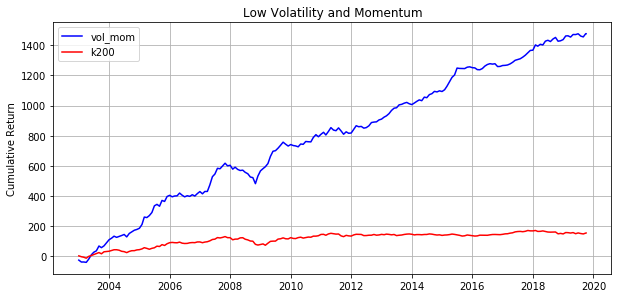

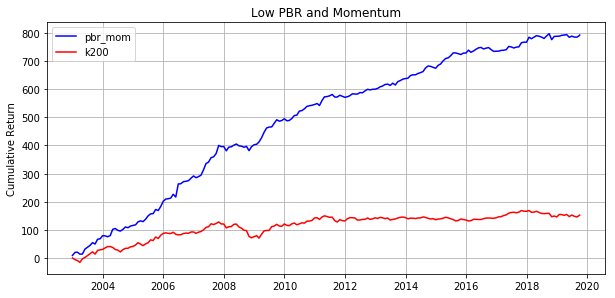

1

In [24]:
smart_beta(mom_tau=12,vol_tau=12,pbr_threshold=3.0,cumulative=False)

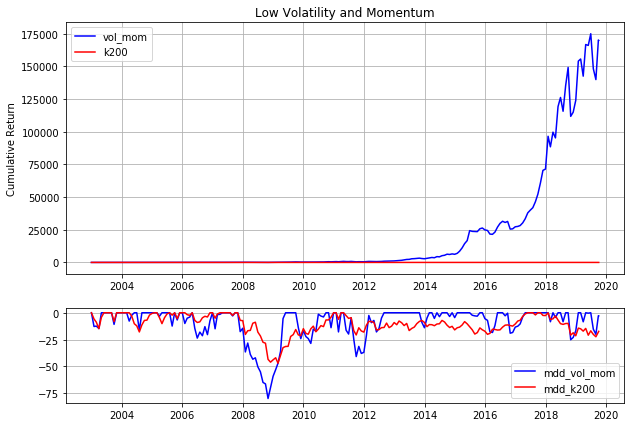

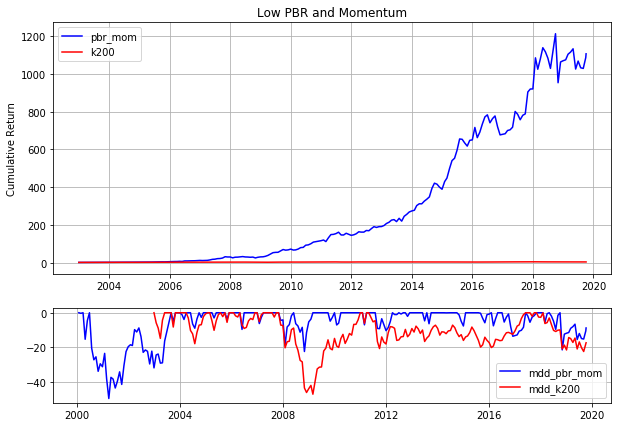

1

In [19]:
smart_beta(mom_tau=12, vol_tau= 12, pbr_threshold=3.0, cumulative=True)